## Load libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import datetime
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers

from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
import imageio as iio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

from tensorflow.keras import callbacks

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.models import save_model, load_model

import tensorflow as tf
%load_ext tensorboard


# # Clear any logs from previous runs
# rm -rf ./logs/


In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab Notebooks/sketch-image-search')

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
# Fixed number of classes
NUM_CLASSES = 125

# Fixed number of channels
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
TOTAL_NUM_EPOCHS = 60000
NUM_EPOCHS = 1  # 60000
EARLY_STOP_PATIENCE = 20

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 1000#00
STEPS_PER_EPOCH_VALIDATION = 1000#00

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 68
BATCH_SIZE_VALIDATION = 68

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

# TRIPLET network with classification extension
LEARNING_RATE = 10**(-5)
WEIGHT_DECAY = 2*(10**(-3))

MARGIN = 15
C1 = 10
C2 = 1



## making the sets

## create (A,P,N,) triplet tuples 

In [ ]:
# search through each sketch (A), pick the corresponding picture (P) and a different picture (N)

In [ ]:
## DEFINE THE LOCATION OF SKETCHES AND PHOTOS 

sketch_dir =  'raw_data/sketch/sketchy/sketchy_full'
photo_dir = 'raw_data/photo/tx_000100000000'

In [ ]:
cat_list_sketchy = os.listdir(sketch_dir)

In [ ]:
## MATCH ONE Negative per Sketch

A_list = []
P_list = []
N_list = []

for cat in cat_list_sketchy:
    
    for sketch in os.listdir(os.path.join(sketch_dir,cat)):

      if sketch[0] == 'n':    # needed to add this because I am taking the sketches from a folder that also has the TU (Joao)

        photo = f'{sketch[:sketch.rfind("-")]}.jpg'   

        photo_list = os.listdir(os.path.join(photo_dir,cat))

        photo_list.pop(os.listdir(os.path.join(photo_dir,cat)).index(photo))
        photo_neg = random.choice(photo_list)
                
        A_list.append(os.path.join(sketch_dir,cat,sketch))        
        P_list.append(os.path.join(photo_dir,cat,photo))
        N_list.append(os.path.join(photo_dir,cat,photo_neg))
   

In [ ]:
A_list[0]

'raw_data/sketch/sketchy/sketchy_full/cabin/n02932400_4194-2.png'

In [ ]:
#@title Default title text
## create datasets

anchor_dataset_1 = tf.data.Dataset.from_tensor_slices(A_list)
positive_dataset_1 = tf.data.Dataset.from_tensor_slices(P_list)
negative_dataset_1 = tf.data.Dataset.from_tensor_slices(N_list)


In [ ]:
negative_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
assert (iio.imread(A_list[0])).shape == (iio.imread(P_list[0])).shape
assert (iio.imread(A_list[0])).shape == (iio.imread(N_list[0])).shape
assert len(A_list) == len(P_list)
assert len(A_list) == len(N_list)


In [ ]:
#shape of the images and sketches input for the siamese network
initial_shape = (iio.imread(N_list[0])).shape[0:2]
initial_shape

(256, 256)

In [ ]:
TARGET_SHAPE = (224,224)

In [ ]:
len(cat_list_sketchy)

125

In [ ]:
## PREPROCESSING FUNCTIONS (different functions for image and sketch)

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    # image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE)

    image = preprocess_input(image)

    return image

def preprocess_sketch(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.io.decode_png(image_string, channels=3)
    # image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE)

    image = preprocess_input(image)

    return image

def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_sketch(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [ ]:
##organize in tuple and shuffle

anchor_dataset = anchor_dataset_1.map(preprocess_sketch)
positive_dataset = positive_dataset_1.map(preprocess_image)
negative_dataset = negative_dataset_1.map(preprocess_image)


dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)

In [ ]:
# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(len(A_list) * 0.8))
val_dataset = dataset.skip(round(len(A_list) * 0.8))

train_dataset = train_dataset.batch(BATCH_SIZE_TRAINING, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(BATCH_SIZE_TESTING, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

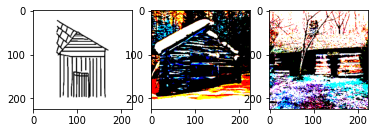

In [ ]:
# checking a (sketch, matching image, not matching image, ) tuple
fig, axs = plt.subplots(1,3)

counter = 1
i=0
for element in dataset:

    i += 1
    if i == counter :
      plt.imshow(element[0])

      axs[0].imshow(element[0])
      axs[1].imshow(element[1])
      axs[2].imshow(element[2])

      break


In [ ]:
element[0].shape

TensorShape([224, 224, 3])

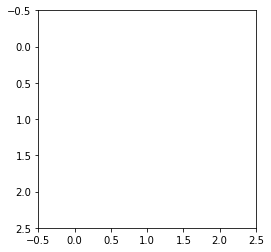

In [ ]:
plt.imshow(np.ones([3,3,3],dtype=int)*255)

## embedding generator models

### sketchs model

In [ ]:
sketch_model = load_model('ResNet_sketch_full_sketchy_baseline_data_aug.h5')

In [ ]:
sketch_model_sketchy = Sequential()

for layer in sketch_model.layers[:-1]:
  layer.trainable = False
  sketch_model_sketchy.add(layer)  



In [ ]:
sketch_embedding = Sequential([
      layers.InputLayer(input_shape=TARGET_SHAPE + (3,)),
      sketch_model_sketchy,
      layers.Flatten(),
      layers.Dense(1024, activation="relu"), 
      layers.BatchNormalization(),
      layers.Dense(32*2)
      ])

In [ ]:
sketch_embedding.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                65600     
                                                                 
Total params: 25,755,584
Trainable params: 2,165,824
Non-trainable params: 23,589,760
__________________________________

### photos model

In [ ]:
photo_model = load_model('ResNet_photos_1_extra_layer.h5')

In [ ]:
photo_model_sketchy = Sequential()

for layer in photo_model.layers[:-1]:
  layer.trainable = False
  photo_model_sketchy.add(layer)   

# photo_model_sketchy.add(Dense(NUM_CLASSES, activation='softmax'))   # here to adjust number of categories (not needed after we have a sketch model trained on sketchy)

In [ ]:
photo_embedding = Sequential([
      # layers.Resizing(IMAGE_RESIZE, IMAGE_RESIZE),
      layers.InputLayer(input_shape=TARGET_SHAPE + (3,)),
      photo_model_sketchy,
      layers.Flatten(),
      # layers.Dense(512, activation="relu"),
      # layers.BatchNormalization(),
      layers.Dense(1024, activation="relu"),
      layers.BatchNormalization(),
      layers.Dense(32*2)
      ])

In [ ]:
photo_embedding.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 128)               23849984  
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              132096    
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 64)                65600     
                                                                 
Total params: 24,051,776
Trainable params: 199,744
Non-trainable params: 23,852,032
____________________________________

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive))#, -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative))#, -1)
        # print(tf.print(ap_distance))

        return (ap_distance, an_distance)



In [ ]:
anchor_input = layers.Input(name="anchor", shape=TARGET_SHAPE + (3,))
positive_input = layers.Input(name="positive", shape=TARGET_SHAPE + (3,))
negative_input = layers.Input(name="negative", shape=TARGET_SHAPE + (3,))

distances = DistanceLayer()(
    sketch_embedding((anchor_input)),
    photo_embedding((positive_input)),
    photo_embedding((negative_input)),
)


siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = c1*‖f(A) - f(P)‖² + c2*max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5, c1=1, c2=1):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        self.c1 = c1
        self.c2 = c2

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.

        loss = ap_distance - an_distance

        loss = self.c1*ap_distance + self.c2*tf.maximum((loss + self.margin), 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                          

In [ ]:

IMAGE_FULL_MODEL = "triplet_full_baseline_68_batch_1000_steps_weights_no_class_layer_c1_1"

model_checkpoint_full = callbacks.ModelCheckpoint("{}.tf".format(IMAGE_FULL_MODEL), monitor="loss", verbose=0, save_best_only=True,save_weights_only=True)

LR_reducer_full = callbacks.ReduceLROnPlateau(monitor="loss", factor = WEIGHT_DECAY, patience=10, verbose=1, min_lr=0)
LR_exp_reducer_full = ExponentialDecay(initial_learning_rate = LEARNING_RATE, decay_steps = 1000, decay_rate = WEIGHT_DECAY,)

early_stopper_full = callbacks.EarlyStopping(monitor='loss', patience=EARLY_STOP_PATIENCE, verbose=0, restore_best_weights=True)

full_model_callbacks = [model_checkpoint_full, early_stopper_full, LR_reducer_full]
# full_model_callbacks = [early_stopper_full, LR_reducer_full]

In [ ]:
siamese_model = SiameseModel(siamese_network, margin=MARGIN)
# compile_model(siamese_model)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE))

In [ ]:
# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
TOTAL_NUM_EPOCHS = 3000# 60000
NUM_EPOCHS = 15  # 60000

TOTAL_NUM_EPOCHS/NUM_EPOCHS

200.0

In [ ]:
for epoch_cycle in range(int(TOTAL_NUM_EPOCHS/NUM_EPOCHS)):

  siamese_model.fit(train_dataset, 
                  epochs=NUM_EPOCHS, 
                  steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
                  batch_size =  BATCH_SIZE_TRAINING ,
                  callbacks=full_model_callbacks,
                  workers=8,
                  verbose=1,
                  use_multiprocessing=True)
  
  siamese_model.margin = 0.8*siamese_model.margin
  siamese_model.c1 = siamese_model.margin

  photo_embedding.save(f'photo_embedding_ep_cycle_{epoch_cycle}_{IMAGE_FULL_MODEL}.h5')
  sketch_embedding.save(f'sketch_embedding_ep_cycle_{epoch_cycle}_{IMAGE_FULL_MODEL}.h5')